<a href="https://colab.research.google.com/github/01star01ek/01star01ek/blob/main/latent%EB%B9%84%EA%B5%90_deepfake_small_V3_%EC%9E%90%EB%8F%99%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install dependency

In [11]:
!pip install mediapipe==0.10.11
!pip install opencv-contrib-python flatbuffers==23.5.26 sounddevice==0.4.6 attrs==23.1.0
!pip install torch==2.1.0 torchvision==0.16.0
!pip install dlib opencv-python scikit-image pillow matplotlib imageio gdown tqdm
!pip install ninja tensorboard tensorboardX pyaml pyrallis ftfy
!pip install face-alignment==1.3.5

In [2]:
!pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.18.0 requires flatbuffers>=24.3.25, but you have flatbuffers 23.5.26 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
!mkdir -p /content/extract_frames
!mkdir -p /content/input_videos
!mkdir -p /content/alignmented_frame
!mkdir -p /content/alignmented_frame_aligned
!mkdir -p /content/alignmented_frame_croped
!mkdir -p /content/alignmented_frame_transforms

#git hub & model install

In [2]:
!git clone https://github.com/yuval-alaluf/stylegan3-editing.git

fatal: destination path 'stylegan3-editing' already exists and is not an empty directory.


## models

In [3]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -P /content/pretrained_models/
!bzip2 -d /content/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2

--2025-06-18 21:29:01--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-06-18 21:29:01--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘/content/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2.2’

shape_predictor_68_ 100%[===================>]  61.07M  9.24MB/s    in 8.1s    

2025-06-18 21:29:10 (7.51 MB/s) - ‘/content/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2.2’ saved [64040097/64040097]

bzip2: Output file /content/pretrained_models/shape_predictor_68_face_landmarks.dat already exists.


In [4]:
!gdown --id 1z_cB187QOc6aqVBdLvYvBjoc93-_EuRm -O /content/pretrained_models/restyle_e4e_sg3.pt
!gdown --id 13q6m-bpe3Ws9en9y45JEx2PHQirStt8N -O /content/pretrained_models/stylegan3-ffhq-1024x1024.pt
!gdown --id 1KW7bjndL3QG3sxBbZxreGHigcCCpsDgn -O /content/pretrained_models/model_ir_se50.pth

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1z_cB187QOc6aqVBdLvYvBjoc93-_EuRm
From (redirected): https://drive.google.com/uc?id=1z_cB187QOc6aqVBdLvYvBjoc93-_EuRm&confirm=t&uuid=036df595-92e7-4297-8ca7-dda2c431accd
To: /content/pretrained_models/restyle_e4e_sg3.pt
100% 809M/809M [00:12<00:00, 63.7MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=13q6m-bpe3Ws9en9y45JEx2PHQirStt8N
From (redirected): https://drive.google.com/uc?id=13q6m-bpe3Ws9en9y45JEx2PHQirStt8N&confirm=t&uuid=88e9e633-57b6-4c3f-951e-131aa7f35c95
To:

In [5]:
!mkdir -p /content/stylegan3-editing/pretrained_models
!cp /content/pretrained_models/shape_predictor_68_face_landmarks.dat /content/stylegan3-editing/pretrained_models/

# preprocess frames

In [6]:
#@title 단일 프로세스 프레임 추출 코드
import cv2
import os
from glob import glob
from tqdm import tqdm

video_dir = "/content/input_videos"  #@param {type:"string"}
output_base = "/content/extract_frames"  #@param {type:"string"}
extract_per_sec = 7  #@param {type:"integer"}

os.makedirs(output_base, exist_ok=True)

def extract_video_frames(video_path):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    output_dir = os.path.join(output_base, video_name)
    os.makedirs(output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = max(1, int(fps // extract_per_sec))

    frame_idx = 0
    frame_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % interval == 0:
            frame_list.append(frame)
        frame_idx += 1

    cap.release()

    # 여기서 한 번에 저장!
    for saved_idx, frame in enumerate(frame_list):
        frame_path = os.path.join(output_dir, f"key_{saved_idx:04d}.jpg")
        cv2.imwrite(frame_path, frame)

    return f"{video_name}: {len(frame_list)} frames saved"

# 실행
video_paths = glob(os.path.join(video_dir, "*.mp4"))
print(f"🎬 총 {len(video_paths)}개의 영상 처리 시작")

for video_path in tqdm(video_paths, desc="📦 Processing videos"):
    msg = extract_video_frames(video_path)

🎬 총 4개의 영상 처리 시작


📦 Processing videos: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


In [7]:
#@title 피치 제한 강화 + 눈뜸 50% 기준 + KeyError 해결 코드
import cv2, os, math, numpy as np, pandas as pd
from glob import glob
from tqdm import tqdm
import mediapipe as mp

# MediaPipe 초기화
mp_face_mesh = mp.solutions.face_mesh
FACE_MESH = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.5
)

# 눈 좌표 인덱스
LEFT_EYE_IDX = [
    33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246,
    33, 173, 157, 158, 159, 160, 161, 246, 33
]
RIGHT_EYE_IDX = [
    362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382,
    362, 398, 384, 385, 386, 387, 388, 466, 362
]

CORE_LEFT_EYE = [33, 160, 158, 133, 153, 144]
CORE_RIGHT_EYE = [362, 385, 387, 263, 373, 380]
LEFT_EYE_VERTICAL = [159, 145]
RIGHT_EYE_VERTICAL = [386, 374]
POSE_IDX = [1, 152, 33, 263, 61, 291]

# 파라미터 설정 - 피치 제한 강화, 눈뜸 기준 완화
YAW_T = 25
PITCH_T = 25  # 35에서 25로 강화 (피치 관대하게 하지 않음)
HEAD_DOWN_BONUS = 1  # 보너스 최소화
ENABLE_ADAPTIVE_EAR = True
EAR_PERCENTILE_HIGH = 37 # 상위 50%를 눈뜬 상태로 판정 (기존 40%에서 완화)
EAR_PERCENTILE_LOW = 10

model_points = np.array([
    (0.0, 0.0, 0.0),
    (0.0, -330.0, -65.0),
    (-225.0, 170.0, -135.0),
    (225.0, 170.0, -135.0),
    (-150.0, -150.0, -125.0),
    (150.0, -150.0, -125.0)
], dtype="double")

def get_mediapipe_landmarks(img):
    h, w = img.shape[:2]
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res = FACE_MESH.process(rgb)
    if not res.multi_face_landmarks:
        return None
    lm = res.multi_face_landmarks[0]
    coords = np.array([[p.x * w, p.y * h] for p in lm.landmark])
    return coords

def estimate_pose_mediapipe(landmarks, img_shape):
    image_points = landmarks[POSE_IDX]
    focal = img_shape[1]
    center = (img_shape[1]/2, img_shape[0]/2)
    cam = np.array([[focal, 0, center[0]], [0, focal, center[1]], [0, 0, 1]], dtype="double")
    dist = np.zeros((4,1))
    success, rv, _ = cv2.solvePnP(model_points, image_points, cam, dist)
    return rv if success else None

def rotation_vector_to_euler(rv):
    rmat, _ = cv2.Rodrigues(rv)
    proj = np.hstack((rmat, np.zeros((3,1))))
    angles = cv2.decomposeProjectionMatrix(proj)[6]
    pitch = math.degrees(math.asin(math.sin(math.radians(angles[1][0]))))
    yaw   = math.degrees(math.asin(math.sin(math.radians(angles[2][0]))))
    roll  = -math.degrees(math.asin(math.sin(math.radians(angles[0][0]))))
    return pitch, yaw, roll

def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)

def enhanced_eye_aspect_ratio(landmarks, is_left=True):
    if is_left:
        outer = landmarks[33]
        inner = landmarks[133]
        v1 = np.linalg.norm(landmarks[159] - landmarks[145])
        v2 = np.linalg.norm(landmarks[158] - landmarks[153])
        v3 = np.linalg.norm(landmarks[160] - landmarks[144])
    else:
        outer = landmarks[362]
        inner = landmarks[263]
        v1 = np.linalg.norm(landmarks[386] - landmarks[374])
        v2 = np.linalg.norm(landmarks[385] - landmarks[373])
        v3 = np.linalg.norm(landmarks[387] - landmarks[380])

    horizontal = np.linalg.norm(outer - inner)
    avg_vertical = (v1 + v2 + v3) / 3.0
    return avg_vertical / horizontal

def calculate_adaptive_ear_thresholds(all_ear_values):
    """영상별 적응형 EAR 임계값 계산 - 50% 기준 적용"""
    if len(all_ear_values) < 5:
        return {
            'high_threshold': 0.23,
            'medium_threshold': 0.18,
            'low_threshold': 0.15,
            'min_threshold': 0.12
        }

    ear_array = np.array(all_ear_values)

    # 50% 기준으로 임계값 설정
    high_threshold = np.percentile(ear_array, 100 - EAR_PERCENTILE_HIGH)  # 상위 50%
    medium_threshold = np.percentile(ear_array, 100 - EAR_PERCENTILE_HIGH * 1.2)  # 상위 60%
    low_threshold = np.percentile(ear_array, 100 - EAR_PERCENTILE_HIGH * 1.5)  # 상위 75%
    min_threshold = np.percentile(ear_array, EAR_PERCENTILE_LOW)  # 하위 10%

    # 최소값 보장
    high_threshold = max(high_threshold, 0.16)  # 더 관대하게
    medium_threshold = max(medium_threshold, 0.13)
    low_threshold = max(low_threshold, 0.10)
    min_threshold = max(min_threshold, 0.07)

    return {
        'high_threshold': high_threshold,
        'medium_threshold': medium_threshold,
        'low_threshold': low_threshold,
        'min_threshold': min_threshold,
        'ear_stats': {
            'mean': np.mean(ear_array),
            'std': np.std(ear_array),
            'min': np.min(ear_array),
            'max': np.max(ear_array),
            'count': len(ear_array)
        }
    }

def is_eye_open_adaptive(landmarks, thresholds, pitch_angle=0):
    """적응형 EAR 기반 눈뜸 판정 - 피치 조정 최소화"""

    left_eye_basic = landmarks[CORE_LEFT_EYE]
    right_eye_basic = landmarks[CORE_RIGHT_EYE]

    basic_left_ear = eye_aspect_ratio(left_eye_basic)
    basic_right_ear = eye_aspect_ratio(right_eye_basic)
    basic_avg_ear = (basic_left_ear + basic_right_ear) / 2.0

    enhanced_left_ear = enhanced_eye_aspect_ratio(landmarks, True)
    enhanced_right_ear = enhanced_eye_aspect_ratio(landmarks, False)
    enhanced_avg_ear = (enhanced_left_ear + enhanced_right_ear) / 2.0

    ear_difference = abs(basic_left_ear - basic_right_ear)

    # 피치 조정 최소화 (관대하게 하지 않음)
    pitch_factor = 1.0
    if pitch_angle > 20:  # 20도 이상에서만 최소 조정
        pitch_factor = max(0.95, 1.0 - (pitch_angle - 20) * 0.005)  # 최대 5%만 완화

    # 적응형 임계값 적용
    adj_high = thresholds['high_threshold'] * pitch_factor
    adj_medium = thresholds['medium_threshold'] * pitch_factor
    adj_low = thresholds['low_threshold'] * pitch_factor
    adj_min = thresholds['min_threshold'] * pitch_factor

    # 4단계 눈뜸 판정
    level_1 = (basic_avg_ear > adj_high and
               enhanced_avg_ear > adj_high * 0.9 and
               basic_left_ear > adj_medium and
               basic_right_ear > adj_medium and
               ear_difference < 0.08)

    level_2 = (basic_avg_ear > adj_medium and
               enhanced_avg_ear > adj_medium * 0.8 and
               basic_left_ear > adj_low and
               basic_right_ear > adj_low and
               ear_difference < 0.12)

    level_3 = (basic_avg_ear > adj_low and
               basic_left_ear > adj_min and
               basic_right_ear > adj_min and
               ear_difference < 0.15)

    level_4 = (basic_avg_ear > adj_min and
               basic_left_ear > adj_min * 0.8 and
               basic_right_ear > adj_min * 0.8)

    # 레벨별 점수 부여
    if level_1:
        eye_level = 4
    elif level_2:
        eye_level = 3
    elif level_3:
        eye_level = 2
    elif level_4:
        eye_level = 1
    else:
        eye_level = 0

    return eye_level, {
        'basic_ear': basic_avg_ear,
        'enhanced_ear': enhanced_avg_ear,
        'left_ear': basic_left_ear,
        'right_ear': basic_right_ear,
        'ear_diff': ear_difference,
        'eye_level': eye_level,
        'pitch_factor': pitch_factor,
        'thresholds_used': {
            'high': adj_high,
            'medium': adj_medium,
            'low': adj_low,
            'min': adj_min
        }
    }

def frontal_score_strict_pitch(c):
    """피치 제한 강화된 정면성 평가 함수"""

    yaw_angle = abs(c['yaw'])
    pitch_angle = c['pitch']

    # 엄격한 각도 제한 (피치 관대하게 하지 않음)
    if yaw_angle > YAW_T:  # 25도
        return -1000
    if abs(pitch_angle) > PITCH_T:  # ±25도 (엄격)
        return -1000

    # 기본 페널티 (피치에 더 큰 가중치)
    yaw_penalty = yaw_angle * 0.8
    pitch_penalty = abs(pitch_angle) * 1.2  # 피치 페널티 증가

    # 고개 숙임 보너스 최소화
    head_down_bonus = 0
    if -15 <= pitch_angle <= -5:  # 아주 제한적인 범위에서만
        head_down_bonus = HEAD_DOWN_BONUS * 0.5  # 보너스도 절반으로

    # 눈뜸 레벨 보너스
    eye_level = c.get('eye_level', 0)
    eye_bonus = eye_level * 12  # 눈뜸이 더 중요

    bonus = eye_bonus + (head_down_bonus if pitch_angle < 0 else 0)

    return -(0.5 * yaw_penalty + 0.5 * pitch_penalty) + bonus

def calculate_final_quality_score(pitch, yaw, eye_level, ear_details):
    """최종 품질 점수 계산 - 피치 페널티 강화"""

    # 각도 점수 (피치에 더 큰 페널티)
    yaw_score = max(0, 100 - abs(yaw) * 2.0)
    pitch_score = max(0, 100 - abs(pitch) * 2.5)  # 피치 페널티 증가
    angle_score = (yaw_score + pitch_score) / 2

    # 눈뜸 레벨 점수 (50% 기준이므로 더 관대)
    eye_score = eye_level * 25

    # EAR 품질 점수
    ear_quality = min(100, ear_details['basic_ear'] * 300)

    # 종합 점수 (눈뜸 비중 증가)
    total_score = (
        angle_score * 0.3 +    # 각도 30%
        eye_score * 0.5 +      # 눈뜸 50% (증가)
        ear_quality * 0.2      # EAR 품질 20%
    )

    return total_score

# 경로 설정
INPUT_ROOT = "/content/extract_frames"
OUTPUT_ROOT = "/content/alignmented_frame"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

file_ext = ".jpg"
video_dirs = [d for d in os.listdir(INPUT_ROOT) if os.path.isdir(os.path.join(INPUT_ROOT, d))]
missing_videos = []
detailed_log = []
best_images = []
best_names = []

print(f"📦 총 {len(video_dirs)}개 영상 처리 시작")
print(f"🎯 눈뜸 기준: 상위 {EAR_PERCENTILE_HIGH}% (50% 기준으로 완화)")
print(f"📐 각도 제한: Yaw ±{YAW_T}°, Pitch ±{PITCH_T}° (피치 제한 강화)")
print(f"🎁 고개 숙임 보너스: {HEAD_DOWN_BONUS}점 (최소화)")

for video_name in tqdm(video_dirs, desc="🎯 Strict pitch + 50% eye threshold"):
    input_dir = os.path.join(INPUT_ROOT, video_name)

    # 1단계: 모든 프레임의 EAR 값 수집
    all_ear_values = []
    frame_data = []

    for f in sorted(os.listdir(input_dir)):
        if not f.lower().endswith(file_ext):
            continue

        full_path = os.path.join(input_dir, f)
        img = cv2.imread(full_path)
        if img is None:
            continue

        lm = get_mediapipe_landmarks(img)
        if lm is None:
            continue

        rv = estimate_pose_mediapipe(lm, img.shape)
        if rv is None:
            continue

        pitch, yaw, _ = rotation_vector_to_euler(rv)

        # 엄격한 각도 제한
        if abs(yaw) > YAW_T * 1.5 or abs(pitch) > PITCH_T * 1.5:
            continue

        # EAR 계산
        left_eye = lm[CORE_LEFT_EYE]
        right_eye = lm[CORE_RIGHT_EYE]
        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        avg_ear = (left_ear + right_ear) / 2.0

        all_ear_values.append(avg_ear)

        # 프레임 데이터 저장
        x1, y1 = lm[:,0].min(), lm[:,1].min()
        x2, y2 = lm[:,0].max(), lm[:,1].max()
        face_area = (x2 - x1) * (y2 - y1)
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

        frame_data.append({
            'img': img,
            'filename': f,
            'landmarks': lm,
            'pitch': pitch,
            'yaw': yaw,
            'avg_ear': avg_ear,
            'cx': cx,
            'cy': cy,
            'face_area': face_area
        })

    if not all_ear_values:
        missing_videos.append(video_name)
        detailed_log.append({
            'video_name': video_name,
            'total_frames': 0,
            'selected': False,
            'selection_level': 0,  # KeyError 방지를 위해 추가
            'reason': 'No valid frames found'
        })
        continue

    # 2단계: 적응형 임계값 계산 (50% 기준)
    thresholds = calculate_adaptive_ear_thresholds(all_ear_values)

    # 3단계: 4단계 후보 분류
    level_4_candidates = []
    level_3_candidates = []
    level_2_candidates = []
    level_1_candidates = []

    for frame in frame_data:
        # 엄격한 피치 제한 적용
        if abs(frame['pitch']) > PITCH_T:
            continue

        eye_level, eye_details = is_eye_open_adaptive(
            frame['landmarks'], thresholds, abs(frame['pitch'])
        )

        if eye_level == 0:
            continue

        candidate = {
            'img': frame['img'],
            'filename': frame['filename'],
            'pitch': frame['pitch'],
            'yaw': frame['yaw'],
            'cx': frame['cx'],
            'cy': frame['cy'],
            'face_area': frame['face_area'],
            'w': frame['img'].shape[1],
            'h': frame['img'].shape[0],
            'eye_level': eye_level,
            'eye_details': eye_details,
            'quality_score': calculate_final_quality_score(
                frame['pitch'], frame['yaw'], eye_level, eye_details
            )
        }

        if eye_level == 4:
            level_4_candidates.append(candidate)
        elif eye_level == 3:
            level_3_candidates.append(candidate)
        elif eye_level == 2:
            level_2_candidates.append(candidate)
        else:
            level_1_candidates.append(candidate)

    # 4단계: 최적 프레임 선택
    best_img = None
    best_filename = None
    selection_reason = "No suitable frames"
    selection_level = 0

    if level_4_candidates:
        best = max(level_4_candidates, key=frontal_score_strict_pitch)
        best_img = best['img']
        best_filename = best['filename']
        selection_reason = f"Level 4: Selected from {len(level_4_candidates)} highest quality candidates"
        selection_level = 4

    elif level_3_candidates:
        best = max(level_3_candidates, key=frontal_score_strict_pitch)
        best_img = best['img']
        best_filename = best['filename']
        selection_reason = f"Level 3: Selected from {len(level_3_candidates)} high quality candidates"
        selection_level = 3

    elif level_2_candidates:
        best = max(level_2_candidates, key=frontal_score_strict_pitch)
        best_img = best['img']
        best_filename = best['filename']
        selection_reason = f"Level 2: Selected from {len(level_2_candidates)} medium quality candidates"
        selection_level = 2

    elif level_1_candidates:
        best = max(level_1_candidates, key=lambda x: x['quality_score'])
        best_img = best['img']
        best_filename = best['filename']
        selection_reason = f"Level 1: Selected from {len(level_1_candidates)} minimum quality candidates"
        selection_level = 1

    elif frame_data:
        # 최후의 수단: 가장 품질 좋은 프레임 무조건 선택
        best_frame = max(frame_data, key=lambda x: x['avg_ear'])
        best_img = best_frame['img']
        best_filename = best_frame['filename']
        selection_reason = f"Emergency: Selected best EAR frame ({best_frame['avg_ear']:.3f})"
        selection_level = 0

    # KeyError 방지를 위한 안전한 로그 기록
    detailed_log.append({
        'video_name': video_name,
        'total_frames': len(frame_data),
        'level_4_candidates': len(level_4_candidates),
        'level_3_candidates': len(level_3_candidates),
        'level_2_candidates': len(level_2_candidates),
        'level_1_candidates': len(level_1_candidates),
        'selected': best_filename is not None,
        'selection_level': selection_level,  # 항상 포함
        'best_filename': best_filename,
        'reason': selection_reason,
        'ear_thresholds': thresholds,
        'quality_score': best.get('quality_score', 0) if 'best' in locals() else 0
    })

    # 프레임 저장
    if best_img is not None:
        save_path = os.path.join(OUTPUT_ROOT, f"{video_name}.jpg")
        cv2.imwrite(save_path, best_img)

        if selection_level <= 1:
            print(f"⚠️  {video_name}: Low quality selection (Level {selection_level})")
    else:
        missing_videos.append(video_name)

# 결과 저장
if missing_videos:
    df_missing = pd.DataFrame(missing_videos, columns=["video_name"])
    df_missing.to_csv("no_frame_found.csv", index=False)
    print(f"❗ {len(missing_videos)}개 영상에서 프레임을 찾지 못함")

df_log = pd.DataFrame(detailed_log)
df_log.to_csv("strict_pitch_50percent_eye_log.csv", index=False)
print(f"📊 처리 결과 저장: strict_pitch_50percent_eye_log.csv")

# KeyError 방지된 안전한 통계 출력
success_rate = (len(video_dirs) - len(missing_videos)) / len(video_dirs) * 100 if video_dirs else 0

# .get() 메서드 사용으로 KeyError 방지
level_4_usage = sum(1 for log in detailed_log if log.get('selection_level', 0) == 4)
level_3_usage = sum(1 for log in detailed_log if log.get('selection_level', 0) == 3)
level_2_usage = sum(1 for log in detailed_log if log.get('selection_level', 0) == 2)
level_1_usage = sum(1 for log in detailed_log if log.get('selection_level', 0) == 1)
emergency_usage = sum(1 for log in detailed_log if log.get('selection_level', 0) == 0)

print(f"✅ 성공률: {success_rate:.1f}% ({len(video_dirs) - len(missing_videos)}/{len(video_dirs)})")
print(f"🏆 Level 4 (최고품질): {level_4_usage}개")
print(f"🥈 Level 3 (고품질): {level_3_usage}개")
print(f"🥉 Level 2 (중품질): {level_2_usage}개")
print(f"📉 Level 1 (최소품질): {level_1_usage}개")
print(f"🚨 Emergency (강제선택): {emergency_usage}개")

print(f"\n📈 품질 분포:")
print(f"   - 고품질 이상 (Level 3+): {(level_4_usage + level_3_usage) / len(video_dirs) * 100:.1f}%")
print(f"   - 중품질 이상 (Level 2+): {(level_4_usage + level_3_usage + level_2_usage) / len(video_dirs) * 100:.1f}%")
print(f"   - 최소품질 이상 (Level 1+): {(len(video_dirs) - emergency_usage) / len(video_dirs) * 100:.1f}%")

print(f"\n🎯 설정 요약:")
print(f"   - 피치 제한: ±{PITCH_T}° (엄격)")
print(f"   - 눈뜸 기준: 상위 {EAR_PERCENTILE_HIGH}% (관대)")
print(f"   - 고개 숙임 보너스: {HEAD_DOWN_BONUS}점 (최소)")


📦 총 4개 영상 처리 시작
🎯 눈뜸 기준: 상위 37% (50% 기준으로 완화)
📐 각도 제한: Yaw ±25°, Pitch ±25° (피치 제한 강화)
🎁 고개 숙임 보너스: 1점 (최소화)


🎯 Strict pitch + 50% eye threshold: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

📊 처리 결과 저장: strict_pitch_50percent_eye_log.csv
✅ 성공률: 100.0% (4/4)
🏆 Level 4 (최고품질): 2개
🥈 Level 3 (고품질): 2개
🥉 Level 2 (중품질): 0개
📉 Level 1 (최소품질): 0개
🚨 Emergency (강제선택): 0개

📈 품질 분포:
   - 고품질 이상 (Level 3+): 100.0%
   - 중품질 이상 (Level 2+): 100.0%
   - 최소품질 이상 (Level 1+): 100.0%

🎯 설정 요약:
   - 피치 제한: ±25° (엄격)
   - 눈뜸 기준: 상위 37% (관대)
   - 고개 숙임 보너스: 1점 (최소)


In [8]:
import numpy
print(numpy.__version__)

1.26.4


# image crop

In [12]:
%cd /content/stylegan3-editing

/content/stylegan3-editing


In [13]:
import sys
sys.path.append('/content/stylegan3-editing')

In [16]:
import time
base_raw_root = "/content/alignmented_frame"
aligned_root = f"{base_raw_root}_aligned"
cropped_root = f"{base_raw_root}_croped"
transform_root = f"{base_raw_root}_transforms"

print("🚀 Aligning all images...")
# 실행 명령어에 PYTHONPATH를 추가하여 모듈을 찾을 경로를 알려줍니다.
!PYTHONPATH=/content/stylegan3-editing python /content/stylegan3-editing/prepare_data/preparing_faces_parallel.py \
    --mode align \
    --root_path "{base_raw_root}"

time.sleep(3)

print("🔁 Cropping all images...")
# 여기도 동일하게 추가합니다.
!PYTHONPATH=/content/stylegan3-editing python /content/stylegan3-editing/prepare_data/preparing_faces_parallel.py \
    --mode crop \
    --root_path "{base_raw_root}" \
    --random_shift 0.05

time.sleep(3)

print("🔁 Computing transforms for all images...")
# 여기도 동일하게 추가합니다.
!PYTHONPATH=/content/stylegan3-editing python /content/stylegan3-editing/prepare_data/compute_landmarks_transforms.py \
    --raw_root "{base_raw_root}" \
    --aligned_root "{aligned_root}" \
    --cropped_root "{cropped_root}" \
    --output_root "{transform_root}"


🚀 Aligning all images...
1
Running on 4 paths
Here we goooo
	ForkPoolWorker-1 is starting to extract on #4 images
	Done!
Mischief managed in -2.17536997795105s
🔁 Cropping all images...
1
Running on 4 paths
Here we goooo
	ForkPoolWorker-1 is starting to extract on #4 images
	Done!
Mischief managed in -2.1390206813812256s
🔁 Computing transforms for all images...
Computing landmarks transforms...
100% 4/4 [00:08<00:00,  2.02s/it]


In [17]:
import os

# 디렉토리 설정
input_root = "/content/alignmented_frame_croped"
transforms_root = "/content/alignmented_frame_transforms/landmarks_transforms.npy"
output_root = "/content/experiments/restyle_e4e_sg3"
ckpt_path = "/content/pretrained_models/restyle_e4e_sg3.pt"
script_path = "/content/stylegan3-editing/inversion/scripts/inference_iterative.py"

# output 디렉토리 생성
os.makedirs(output_root, exist_ok=True)

print("🚀 Inverting video")

!python {script_path} \
    --output_path "{output_root}" \
    --checkpoint_path "{ckpt_path}" \
    --data_path "{input_root}" \
    --test_batch_size 4 \
    --test_workers 4 \
    --n_iters_per_batch 3 \
    --landmarks_transforms_path "{transforms_root}"

🚀 Inverting video
Loading ReStyle e4e from checkpoint: /content/pretrained_models/restyle_e4e_sg3.pt
Loading StyleGAN3 generator from path: None
Done!
Model successfully loaded!
Loading dataset for ffhq_encode
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
  0% 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what

# save CSV

In [18]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# 1. Load latent dictionary
latent_path = "/content/experiments/restyle_e4e_sg3/latents.npy"
latent_dict = np.load(latent_path, allow_pickle=True).item()

# 2. 정렬된 파일 리스트 확보
filenames = sorted(latent_dict.keys())

# 3. 각 latent에서 마지막 step → 평균 → (512,)
latents = []
for key in filenames:
    latent = latent_dict[key][-1]  # 마지막 step (18, 512)
    mean_latent = latent.mean(axis=0).astype('float32')  # (512,)
    latents.append(mean_latent)

latents = np.stack(latents)  # shape: (N, 512)

# 4. cosine similarity matrix
sim_matrix = cosine_similarity(latents)  # shape: (N, N)

# 5. 각 query 파일마다 top-3 유사한 match + score 저장
rows = []

for i in range(len(filenames)):
    sims = sim_matrix[i].copy()
    sims[i] = -np.inf  # 자기 자신 제외
    top3_idx = np.argsort(sims)[::-1][:3]
    row = {
        "query": filenames[i],
        "top1": filenames[top3_idx[0]],
        "top2": filenames[top3_idx[1]],
        "top3": filenames[top3_idx[2]],
        "top1val": round(float(sims[top3_idx[0]]), 6),
        "top2val": round(float(sims[top3_idx[1]]), 6),
        "top3val": round(float(sims[top3_idx[2]]), 6),
    }
    rows.append(row)

# 6. Save to CSV
df = pd.DataFrame(rows)
df.to_csv("video_similarity_top3_compact.csv", index=False)

print("✅ Saved to video_similarity_top3_compact.csv")


✅ Saved to video_similarity_top3_compact.csv


📂 Loading original latent vectors...
📁 Preparing input images for inversion...
🚀 Running inversion on generated images...
🔍 Comparing latents...
✅ 비교 결과 저장 완료: /content/original_vs_generated_latent_comparison.csv


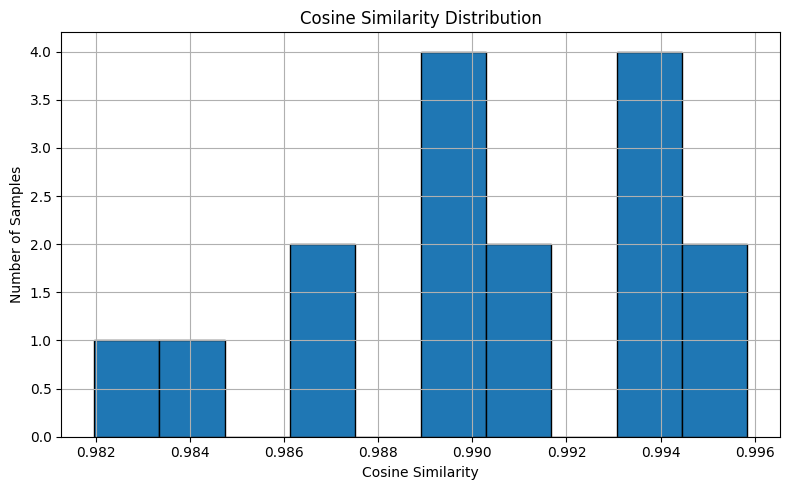

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import subprocess

# === 경로 설정 ===
original_latent_path = "/content/experiments/restyle_e4e_sg3/latents.npy"
generated_image_dir = "/content/experiments/restyle_e4e_sg3/inference_results/0"
temp_input_dir = "/content/temp_comparison/generated_input"
temp_output_dir = "/content/temp_comparison/generated_output"
generated_latent_path = os.path.join(temp_output_dir, "latents.npy")
script_path = "/content/stylegan3-editing/inversion/scripts/inference_iterative.py"
ckpt_path = "/content/pretrained_models/restyle_e4e_sg3.pt"

# === Step 1. 원본 latent 불러오기 ===
print("📂 Loading original latent vectors...")
orig_latent_raw = np.load(original_latent_path, allow_pickle=True).item()
original_latents = {}
for k, v in orig_latent_raw.items():
    key = os.path.splitext(os.path.basename(k))[0]
    final_latent = v[-1]
    original_latents[key] = {
        "mean": final_latent.mean(axis=0).astype("float32"),
        "full": final_latent
    }

# === Step 2. Generated 이미지 latent 재추출 ===
print("📁 Preparing input images for inversion...")
os.makedirs(temp_input_dir, exist_ok=True)
os.makedirs(temp_output_dir, exist_ok=True)

# 이미지 복사
from glob import glob
import shutil
for path in glob(os.path.join(generated_image_dir, "*.jpg")):
    fname = os.path.basename(path)
    new_name = f"0_{fname}"  # prefix 붙이기 (중복 방지)
    shutil.copy(path, os.path.join(temp_input_dir, new_name))

# 인버전 실행
print("🚀 Running inversion on generated images...")
subprocess.run([
    "python", script_path,
    "--output_path", temp_output_dir,
    "--checkpoint_path", ckpt_path,
    "--data_path", temp_input_dir,
    "--test_batch_size", "4",
    "--test_workers", "2",
    "--n_iters_per_batch", "3"
], check=True)

# === Step 3. Generated latent 불러오기 및 비교 ===
print("🔍 Comparing latents...")
gen_latent_dict = np.load(generated_latent_path, allow_pickle=True).item()
results = []

for gen_fname, latent_seq in gen_latent_dict.items():
    _, clean = gen_fname.split("_", 1) if "_" in gen_fname else ("", gen_fname)
    base_name = os.path.splitext(clean)[0]

    if base_name not in original_latents:
        print(f"⚠️ 원본 latent 없음: {base_name}")
        continue

    gen_final = latent_seq[-1]
    gen_mean = gen_final.mean(axis=0).astype("float32")
    orig = original_latents[base_name]

    layer_sims = [cosine_similarity([orig["full"][i]], [gen_final[i]])[0][0]
                  for i in range(gen_final.shape[0])]

    results.append({
        "filename": base_name,
        "cosine_similarity": cosine_similarity([orig["mean"]], [gen_mean])[0][0],
        "euclidean_distance": np.linalg.norm(orig["mean"] - gen_mean),
        "dot_product": np.dot(orig["mean"], gen_mean),
        "coarse_similarity": np.mean(layer_sims[:4]),
        "middle_similarity": np.mean(layer_sims[4:8]),
        "fine_similarity": np.mean(layer_sims[8:]),
        "overall_layer_similarity": np.mean(layer_sims),
    })

# === Step 4. 저장 ===
df = pd.DataFrame(results)
csv_path = "/content/original_vs_generated_latent_comparison.csv"
df.to_csv(csv_path, index=False)
print(f"✅ 비교 결과 저장 완료: {csv_path}")

# === Step 5. 시각화 ===
plt.figure(figsize=(8, 5))
plt.hist(df["cosine_similarity"], bins=10, edgecolor='black')
plt.title("Cosine Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()